In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Tải thư viện NLTK cần thiết
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

# Khởi tạo
lemmatizer = WordNetLemmatizer()
captions_by_image = defaultdict(list)

# Đọc dữ liệu caption từ file
with open("/content/drive/MyDrive/GI - ML/datasets/Flickr8k.token.txt", "r") as f:
    for line in f:
        img_id, caption = line.strip().split('\t')
        img_id = img_id.split('#')[0]
        captions_by_image[img_id].append(caption)

# Từ khóa cho color và location
colors = ['red', 'blue', 'green', 'yellow', 'black', 'white', 'brown', 'orange', 'pink', 'purple', 'gray']
locations = ['beach', 'street', 'park', 'field', 'grass', 'snow', 'playground', 'bench', 'lake', 'mountain', 'building']

# Hàm trích xuất 4 thuộc tính
def extract_labels(captions):
    all_nouns, all_verbs = [], []
    found_colors, found_locations = [], []

    for caption in captions:
        tokens = word_tokenize(caption.lower())
        tagged = pos_tag(tokens)

        # Lấy danh từ & động từ đã lemmatize
        nouns = [lemmatizer.lemmatize(w) for w, tag in tagged if tag.startswith("NN")]
        verbs = [lemmatizer.lemmatize(w, "v") for w, tag in tagged if tag.startswith("VB")]

        all_nouns += nouns
        all_verbs += verbs

        # Trích xuất màu và vị trí
        found_colors += [w for w in tokens if w in colors]
        found_locations += [w for w in tokens if w in locations]

    # Đếm tần suất và chọn động từ chính
    most_common_action = Counter(all_verbs).most_common(1)
    most_common_object = Counter(all_nouns).most_common(1)

    return {
        'object': most_common_object[0][0] if most_common_object else None,
        'action': most_common_action[0][0] if most_common_action else None,
        'color': Counter(found_colors).most_common(1)[0][0] if found_colors else None,
        'location': Counter(found_locations).most_common(1)[0][0] if found_locations else None,
    }


# Xử lý toàn bộ ảnh
records = []
for img_id, caps in captions_by_image.items():
    labels = extract_labels(caps)
    labels['image'] = img_id
    records.append(labels)

# Xuất ra CSV
df = pd.DataFrame(records)
df.to_csv("auto_labels_simple.csv", index=False)






In [ ]:
df.head()

,object,action,color,location,image
0,girl,climb,pink,building,1000268201_693b08cb0e.jpg
1,dog,be,black,street,1001773457_577c3a7d70.jpg
2,girl,be,white,grass,1002674143_1b742ab4b8.jpg
3,man,lay,white,bench,1003163366_44323f5815.jpg
4,man,wear,orange,None,1007129816_e794419615.jpg


### Xử lý dữ liệu

In [42]:
for col in ['object', 'action', 'color', 'location']:
    print(f"Unique values in {col}:")
    print(df[col].unique())
    print()


Unique values in object:
['girl' 'dog' 'man' 'child' 'grass' 'boy' 'rock' 'water' 'couple' 'ice'
 'goal' 'people' 'television' 'beach' 'skateboard' 'woman' 'construction'
 'train' 'board' 'skier' 'balloon' 'bike' 'group' 'slide' 'horse'
 'mountain' 'person' 'tunnel' 'air' 'ball' 'road' 'frisbee' 'shirt'
 'fountain' 'bird' 'pool' 'sand' 'flag' 'street' 'men' 'bed' 'snowboarder'
 'walk' 'bridge' 'truck' 'costume' 'short' 'intersection' 'trumpet'
 'drink' 'snow' 'car' 'tree' 'bench' 'swing' 'spoon' 'night' 'pacifier'
 'hat' 'reflection' 'pink' 'cat' 'police' 'pair' 'playpen' 'distance'
 'boat' 'baseball' 'crowd' 'table' 'wall' 'picture' 'bar' 'face' 'track'
 'kid' 'racer' 'puppy' 'adult' 'baby' 'bear' 'head' 'liberty' 'softball'
 'hand' 'climber' 'rope' 'wine' 'bicycle' 'stroller' 'vehicle' 'sidewalk'
 'harness' 'robot' 'lamp' 'player' 'ride' 'food' 'field' 'lady' 'mother'
 'fish' 'pant' 'hill' 'backpack' 'stream' 'cliff' 'toy' 'branch' 'camera'
 'front' 'school' 'vest' 'helmet' 'skateboa

In [48]:
# Chuẩn hóa dữ liệu dạng text
import re

def clean_text(text):
    text = text.lower().strip()
    # Loại bỏ ký tự không phải a-z, dấu cách, dấu phẩy
    text = re.sub(r'[^a-z ,]', '', text)
    return text

def singularize(word):
    # Quy tắc chuyển số nhiều sang số ít đơn giản
    if word.endswith('ies'):
        return word[:-3] + 'y'  # babies -> baby
    elif word.endswith('s') and not word.endswith('ss'):
        return word[:-1]
    return word

def split_compound(text):
    # Tách các phần từ ghép bởi dấu phẩy
    return [part.strip() for part in text.split(',')]

def normalize_list(raw_list):
    normalized = set()
    for item in raw_list:
        if not item:
            continue
        cleaned = clean_text(item)
        parts = split_compound(cleaned)
        for part in parts:
            words = part.split()
            if words and words[0] == 'a':
                words = words[1:]
            if words:
                words[-1] = singularize(words[-1])
                normalized.add(' '.join(words))
    return normalized

# Danh sách raw cũ
raw_objects_old = ['a person', 'a man', 'a woman', 'person', 'man', 'woman', 'male', 'female', 'people', 'dog', 'dogs', 'cat', 'cats', 'child', 'children', 'boy', 'girl', 'baby', 'babies', 'player', 'players', 'athlete', 'athletes', 'player, person', 'horse', 'horses', 'car', 'cars', 'bicycle', 'bicycles', 'motorcycle', 'motorcycles', 'bus', 'buses', 'train', 'trains', 'airplane', 'airplanes', 'boat', 'boats', 'ship', 'ships', 'truck', 'trucks', 'traffic light', 'traffic lights', 'stop sign', 'stop signs', 'parking meter', 'parking meters', 'bench', 'benches', 'bird', 'birds', 'horse, rider', 'rider', 'ski', 'skis', 'snowboard', 'snowboards', 'surfboard', 'surfboards', 'tennis racket', 'tennis rackets', 'bottle', 'bottles', 'wine glass', 'wine glasses', 'cup', 'cups', 'fork', 'forks', 'knife', 'knives', 'spoon', 'spoons', 'bowl', 'bowls', 'banana', 'bananas', 'apple', 'apples', 'sandwich', 'sandwiches', 'orange', 'oranges', 'broccoli', 'broccolis', 'carrot', 'carrots', 'hot dog', 'hot dogs', 'pizza', 'pizzas', 'donut', 'donuts', 'cake', 'cakes', 'chair', 'chairs', 'couch', 'couches', 'potted plant', 'potted plants', 'bed', 'beds', 'dining table', 'dining tables', 'toilet', 'toilets', 'tv', 'tvs', 'laptop', 'laptops', 'mouse', 'mice', 'remote', 'remotes', 'keyboard', 'keyboards', 'cell phone', 'cell phones', 'microwave', 'microwaves', 'oven', 'ovens', 'toaster', 'toasters', 'sink', 'sinks', 'refrigerator', 'refrigerators', 'book', 'books', 'clock', 'clocks', 'vase', 'vases', 'scissors', 'scissor', 'teddy bear', 'teddy bears', 'hair drier', 'hair driers', 'toothbrush', 'toothbrushes']

# Danh sách mới lấy từ DataFrame (giả sử bạn đã có df)
raw_objects_new = df['action'].fillna('').tolist()

# Chuẩn hóa và gộp 2 danh sách
normalized_objects = normalize_list(raw_objects_old)
normalized_objects.update(normalize_list(raw_objects_new))

print("Tổng hợp danh sách các đối tượng chuẩn hóa:")
print(sorted(normalized_objects))


Tổng hợp danh sách các đối tượng chuẩn hóa:
['adjust', 'advertise', 'age', 'aggitate', 'aim', 'airplane', 'appear', 'apple', 'approach', 'athlete', 'attend', 'baby', 'background', 'balance', 'banana', 'bark', 'bath', 'battle', 'be', 'beard', 'bed', 'begin', 'bench', 'benche', 'bend', 'bespectacled', 'bicycle', 'bird', 'bite', 'block', 'blow', 'boat', 'book', 'bottle', 'bounce', 'bound', 'bowl', 'box', 'boy', 'break', 'breathe', 'bring', 'broccoli', 'bu', 'build', 'burn', 'bury', 'buse', 'cake', 'call', 'camp', 'car', 'carpet', 'carring', 'carrot', 'carry', 'carve', 'cast', 'cat', 'catch', 'cave', 'celebrate', 'cell phone', 'chain', 'chair', 'charge', 'chase', 'check', 'cheer', 'chested', 'chew', 'child', 'children', 'clean', 'clear', 'climb', 'clock', 'close', 'collide', 'color', 'come', 'concentrate', 'control', 'cook', 'couch', 'couche', 'cover', 'crash', 'crawl', 'cross', 'crouch', 'crowd', 'cry', 'cup', 'curl', 'cut', 'damage', 'dance', 'dave', 'defend', 'dig', 'dining table', 'div

In [49]:
mapping = {
    'men': 'man',
    'women': 'woman',
    'girls': 'girl',
    'boys': 'boy',
    'children': 'child',
    'people': 'person',
    'persons': 'person',
    'skiers': 'skier',
    'skiing': 'ski',
    'bikers': 'bike',
    'bicycle': 'bike',
    'bicyclist': 'bike',
    'bikes': 'bike',
    'cars': 'car',
    'dogs': 'dog',
    'cats': 'cat',
}
def apply_mapping(word, mapping):
    return mapping.get(word, word)  # Nếu có trong mapping thì thay, không thì giữ nguyên
# Áp dụng mapping lên từng từ trong normalized_objects
normalized_grouped = set()
for phrase in normalized_objects:
    words = phrase.split()

    mapped_words = [apply_mapping(w, mapping) for w in words]
    normalized_grouped.add(' '.join(mapped_words))

print("Danh sách sau khi gom nhóm theo mapping:")
print(sorted(normalized_grouped))


Danh sách sau khi gom nhóm theo mapping:
['adjust', 'advertise', 'age', 'aggitate', 'aim', 'airplane', 'appear', 'apple', 'approach', 'athlete', 'attend', 'baby', 'background', 'balance', 'banana', 'bark', 'bath', 'battle', 'be', 'beard', 'bed', 'begin', 'bench', 'benche', 'bend', 'bespectacled', 'bike', 'bird', 'bite', 'block', 'blow', 'boat', 'book', 'bottle', 'bounce', 'bound', 'bowl', 'box', 'boy', 'break', 'breathe', 'bring', 'broccoli', 'bu', 'build', 'burn', 'bury', 'buse', 'cake', 'call', 'camp', 'car', 'carpet', 'carring', 'carrot', 'carry', 'carve', 'cast', 'cat', 'catch', 'cave', 'celebrate', 'cell phone', 'chain', 'chair', 'charge', 'chase', 'check', 'cheer', 'chested', 'chew', 'child', 'clean', 'clear', 'climb', 'clock', 'close', 'collide', 'color', 'come', 'concentrate', 'control', 'cook', 'couch', 'couche', 'cover', 'crash', 'crawl', 'cross', 'crouch', 'crowd', 'cry', 'cup', 'curl', 'cut', 'damage', 'dance', 'dave', 'defend', 'dig', 'dining table', 'dive', 'do', 'dodge',

In [51]:
import pandas as pd
import numpy as np

# Các giá trị không rõ nghĩa hoặc thiếu cần xử lý
invalid_values = {'something', 'others', 'unknown', '', None, np.nan}

def normalize_unknown(val):
    if pd.isna(val) or str(val).strip().lower() in invalid_values:
        return 'unknown'
    return val

cols_to_process = ['object', 'action', 'color', 'location']

for col in cols_to_process:
    df[col] = df[col].apply(normalize_unknown)



df[cols_to_process].head()


,object,action,color,location
0,girl,climb,pink,building
1,dog,be,black,street
2,girl,be,white,grass
3,man,lay,white,bench
4,man,wear,orange,unknown


In [53]:
import pandas as pd
import numpy as np

# Danh sách các từ không phù hợp/ngữ cảnh cần xử lý
inappropriate_words = {'condom', 'devil', 'evil'}

def handle_inappropriate(val):
    if pd.isna(val):
        return 'unknown'  # Nếu giá trị gốc là NaN thì gán 'unknown'
    val_lower = str(val).lower()
    for bad_word in inappropriate_words:
        if bad_word in val_lower:
            return 'unknown'
    return val

cols_to_check = ['object', 'action', 'color', 'location']

for col in cols_to_check:
    df[col] = df[col].apply(handle_inappropriate)

df.head()




,object,action,color,location,image
0,girl,climb,pink,building,1000268201_693b08cb0e.jpg
1,dog,be,black,street,1001773457_577c3a7d70.jpg
2,girl,be,white,grass,1002674143_1b742ab4b8.jpg
3,man,lay,white,bench,1003163366_44323f5815.jpg
4,man,wear,orange,unknown,1007129816_e794419615.jpg


In [57]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Nếu chưa tải dữ liệu WordNet, chạy 1 lần:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_action(text):
    if pd.isna(text):
        return 'unknown'
    # Xử lý nhiều action trong cùng 1 ô, tách bằng dấu phẩy
    parts = [part.strip() for part in text.lower().split(',')]
    lemmas = []
    for part in parts:
        words = part.split()
        if not words:
            continue
        # Lemmatize từ cuối (giả sử động từ chính)
        lemma = lemmatizer.lemmatize(words[-1], pos='v')  # pos='v' là động từ
        # Thay từ cuối bằng dạng nguyên mẫu
        words[-1] = lemma
        lemmas.append(' '.join(words))
    return ', '.join(lemmas)

df['action'] = df['action'].apply(lemmatize_action)

df['action'].head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,action
0,climb
1,be
2,be
3,lay
4,wear


In [60]:
output_path = '/content/drive/MyDrive/GI - ML/cleaned_data.csv'
df.to_csv(output_path, index=False)


### Trích xuất đặc trưng

In [61]:
from skimage.feature import hog
from skimage import color
from PIL import Image
import numpy as np

def extract_hog_features(image_path):
    # Đọc và chuyển ảnh sang grayscale, resize
    image = Image.open(image_path).resize((128, 128)).convert("L")
    image = np.array(image, dtype=np.float32) / 255.0  # chuẩn hóa về [0, 1]

    # Trích xuất đặc trưng HOG
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )

    return features


### Huấn luyện mô hình

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import os
import numpy as np
from tqdm import tqdm


# Đọc nhãn đã được trích xuất từ file auto_labels_simple.csv
df = pd.read_csv("/content/drive/MyDrive/GI - ML/cleaned_data.csv")

# Thư mục ảnh
image_folder = "/content/drive/MyDrive/GI - ML/datasets/Images"

# Khởi tạo dữ liệu
X = []
y_object = []
y_action = []
y_color = []
y_location = []

print("Extracting features...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = os.path.join(image_folder, row["image"])
    if not os.path.exists(image_path):
        continue

    try:
        feat = extract_hog_features(image_path)
        X.append(feat)
        y_object.append(row["object"])  # Đối tượng
        y_action.append(row["action"])   # Hành động
        y_color.append(row["color"])     # Màu sắc
        y_location.append(row["location"]) # Vị trí
    except Exception as e:
        print(f"Error with {image_path}: {e}")

X = np.array(X)

# Tách dữ liệu
X_train_obj, X_test_obj, y_train_obj, y_test_obj = train_test_split(X, y_object, test_size=0.2, random_state=42)
X_train_act, X_test_act, y_train_act, y_test_act = train_test_split(X, y_action, test_size=0.2, random_state=42)
X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(X, y_color, test_size=0.2, random_state=42)
X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(X, y_location, test_size=0.2, random_state=42)

# Huấn luyện mô hình
clf_obj = RandomForestClassifier(n_estimators=100, random_state=42)
clf_obj.fit(X_train_obj, y_train_obj)

clf_act = RandomForestClassifier(n_estimators=100, random_state=42)
clf_act.fit(X_train_act, y_train_act)

clf_color = RandomForestClassifier(n_estimators=100, random_state=42)
clf_color.fit(X_train_color, y_train_color)

clf_loc = RandomForestClassifier(n_estimators=100, random_state=42)
clf_loc.fit(X_train_loc, y_train_loc)



Extracting features...


100%|██████████| 8092/8092 [02:15<00:00, 59.83it/s]  


RandomForestClassifier(random_state=42)

In [63]:
import joblib
# Save the models
joblib.dump(clf_obj, '/content/drive/MyDrive/GI - ML//rf_object_model.pkl')
joblib.dump(clf_act, '/content/drive/MyDrive/GI - ML//rf_action_model.pkl')
joblib.dump(clf_color, '/content/drive/MyDrive/GI - ML//rf_color_model.pkl')
joblib.dump(clf_loc, '/content/drive/MyDrive/GI - ML//rf_location_model.pkl')

print("Models saved successfully!")

Models saved successfully!


In [ ]:
# Load các mô hình từ file
clf_obj = joblib.load('/content/drive/MyDrive/GI - ML/rf_object_model.pkl')
clf_act = joblib.load('/content/drive/MyDrive/GI - ML/rf_action_model.pkl')
clf_color = joblib.load('/content/drive/MyDrive/GI - ML/rf_color_model.pkl')
clf_loc = joblib.load('/content/drive/MyDrive/GI - ML/rf_location_model.pkl')

print("Models loaded successfully!")


In [64]:
def generate_caption(image_path):
    feat = extract_hog_features(image_path).reshape(1, -1)
    obj = clf_obj.predict(feat)[0]
    act = clf_act.predict(feat)[0]
    color = clf_color.predict(feat)[0]
    loc = clf_loc.predict(feat)[0]

    # Xây dựng từng phần nếu không phải 'unknown'
    parts = []

    if color != 'unknown':
        parts.append(f"{color}")
    if obj != 'unknown':
        parts.append(f"{obj}")

    subject = " ".join(parts) if parts else "something"

    if act != 'unknown':
        verb_phrase = f"is {act}"
    else:
        verb_phrase = ""

    if loc != 'unknown':
        loc_phrase = f"in the {loc}"
    else:
        loc_phrase = ""

    # Kết hợp lại thành câu
    caption_parts = [f"A {subject}"]
    if verb_phrase:
        caption_parts.append(verb_phrase)
    if loc_phrase:
        caption_parts.append(loc_phrase)

    caption = " ".join(caption_parts) + "."

    return caption



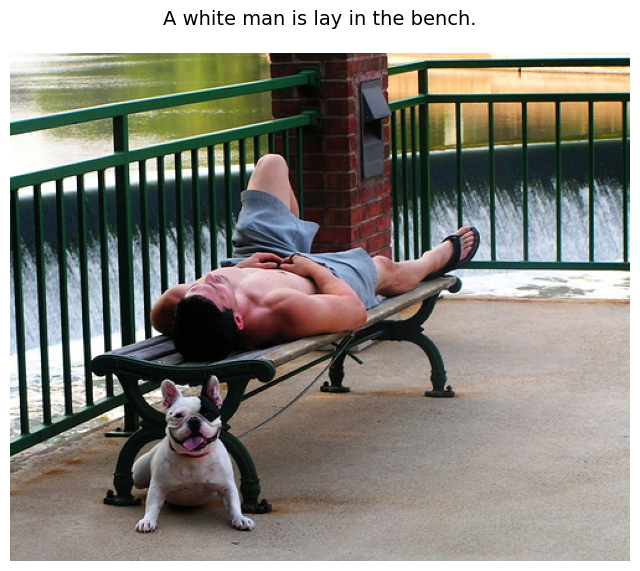

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Đường dẫn tới hình ảnh
image_path = "/content/drive/MyDrive/GI - ML/datasets/Images/1003163366_44323f5815.jpg"

# Sinh caption cho ảnh
caption = generate_caption(image_path)

# Hiển thị ảnh cùng với caption
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Tắt trục tọa độ
plt.title(caption, fontsize=14, pad=20)  # Hiển thị caption dưới ảnh
plt.show()


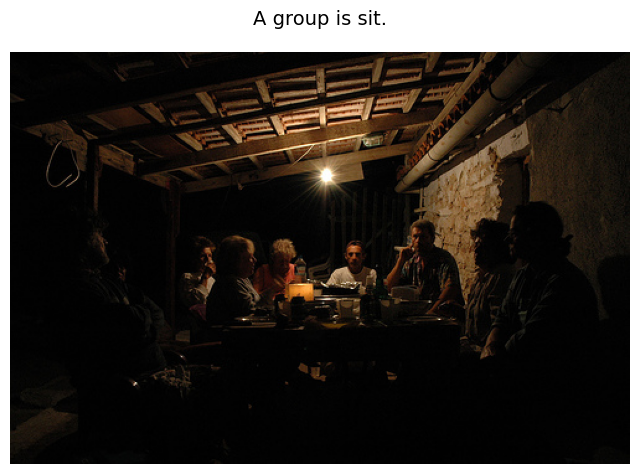

In [66]:
image_path = "/content/drive/MyDrive/GI - ML/datasets/Images/107582366_d86f2d3347.jpg"

# Sinh caption cho ảnh
caption = generate_caption(image_path)
# Hiển thị ảnh cùng với caption
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Tắt trục tọa độ
plt.title(caption, fontsize=14, pad=20)  # Hiển thị caption dưới ảnh
plt.show()

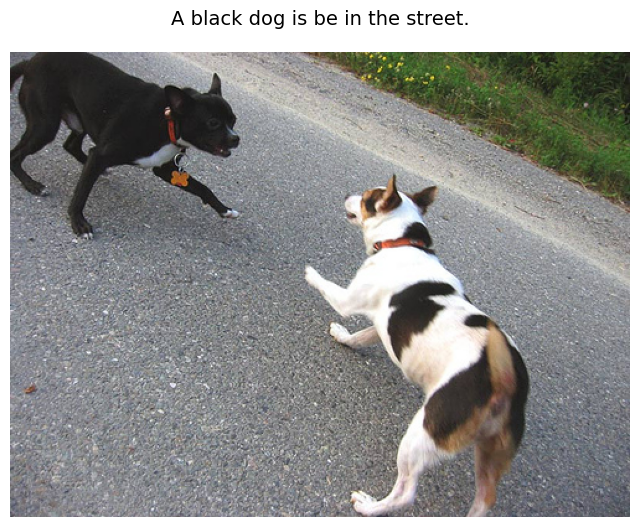

In [71]:
image_path = "/content/drive/MyDrive/GI - ML/datasets/Images/1001773457_577c3a7d70.jpg"

# Sinh caption cho ảnh
caption = generate_caption(image_path)
# Hiển thị ảnh cùng với caption
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Tắt trục tọa độ
plt.title(caption, fontsize=14, pad=20)  # Hiển thị caption dưới ảnh
plt.show()

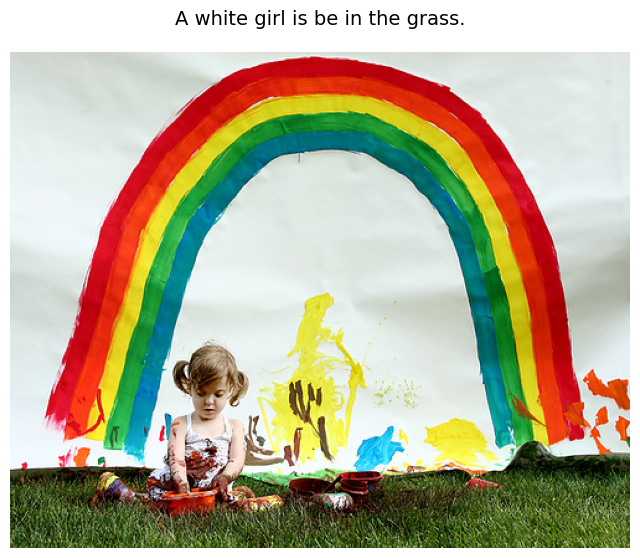

In [72]:
image_path = "/content/drive/MyDrive/GI - ML/datasets/Images/1002674143_1b742ab4b8.jpg"

# Sinh caption cho ảnh
caption = generate_caption(image_path)
# Hiển thị ảnh cùng với caption
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Tắt trục tọa độ
plt.title(caption, fontsize=14, pad=20)  # Hiển thị caption dưới ảnh
plt.show()

In [99]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Nếu chưa cài nltk data thì chạy lần đầu
nltk.download('punkt')

# Đọc các câu tham chiếu từ file
with open('/content/drive/MyDrive/GI - ML/datasets/Flickr8k.token.txt', 'r', encoding='utf-8') as f:
    references = f.readlines()

# Tiền xử lý: lowercase và strip
references = [ref.strip().lower() for ref in references if len(ref.strip()) > 0]

# Tokenize caption sinh ra
candidate = caption.lower()

# Tính BLEU score (câu caption so với toàn bộ tham chiếu)
references_tokenized = [word_tokenize(ref) for ref in references]
candidate_tokenized = word_tokenize(candidate)
bleu_score = sentence_bleu(references_tokenized, candidate_tokenized)
print(f"BLEU score: {bleu_score:.4f}")

# Tính cosine similarity

# Tạo vectorizer
vectorizer = TfidfVectorizer()

# Cùng đưa caption và tất cả câu tham chiếu vào vectorizer
all_sentences = references + [candidate]

# Vector hóa
tfidf_matrix = vectorizer.fit_transform(all_sentences)

# Vector caption là vector cuối cùng
candidate_vec = tfidf_matrix[-1]

# Vector câu tham chiếu là các vector đầu
reference_vecs = tfidf_matrix[:-1]

# Tính cosine similarity giữa caption và từng câu tham chiếu
cosine_similarities = cosine_similarity(candidate_vec, reference_vecs).flatten()

# In kết quả cosine similarity cao nhất và trung bình
print(f"Max cosine similarity: {np.max(cosine_similarities):.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BLEU score: 0.5000
Max cosine similarity: 0.4208


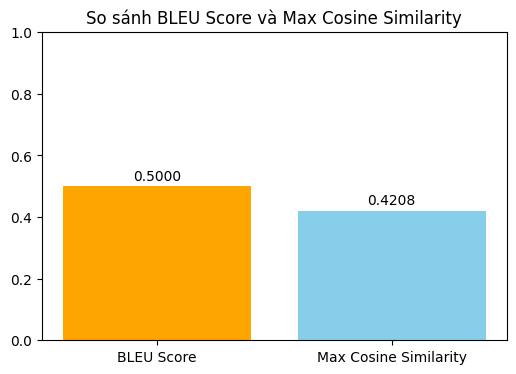

In [103]:
import matplotlib.pyplot as plt

# Hai giá trị bạn đã tính
bleu_score_value = bleu_score
max_cosine_similarity_value = np.max(cosine_similarities)

# Tên các chỉ số
metrics = ['BLEU Score', 'Max Cosine Similarity']
values = [bleu_score_value, max_cosine_similarity_value]

# Vẽ bar chart
plt.figure(figsize=(6,4))
bars = plt.bar(metrics, values, color=['orange', 'skyblue'])

# Ghi giá trị lên trên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.title('So sánh BLEU Score và Max Cosine Similarity')
plt.show()

